In [1]:
import os
import sys
import glob
import math
import time
import random
import itertools
import datetime
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.models import resnet18, resnet50
from torchvision.utils import save_image
import torchvision.transforms as transforms

In [2]:
from torch.utils.data import random_split

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize

In [4]:
from numpy import asarray

In [6]:
class ImageDataset(Dataset):
    def __init__(self, folder1, folder2):
        self.folder1 = folder1
        self.folder2 = folder2
        self.files = sorted(glob.glob(os.path.join(folder1) + "/*.*"))
        self.transform = transforms.Compose(
            [
                # transforms.Resize(input_shape[-2:], Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            ]
        )
        # print(self.files)
    
    def find_corresponding_image(self,folder2, x_image_name):
        # Get the name without extension
        filename = os.path.basename(x_image_name)
        # print("Filename:", filename)
        x_image_name_no_extension, _ = os.path.splitext(filename)
        # print(x_image_name_no_extension)
        # Iterate through files in folder2
        for filename in os.listdir(folder2):
            # Check if filename starts with x_image_name_no_extension and ends with '-a'
            # print(filename)
            if filename.startswith(x_image_name_no_extension):
                return os.path.join(folder2, filename)
        return None

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)]).convert('RGB')
        # print(img.size)
        img = asarray(img)
        # print(img)
        img_A = resize(img, (256,256), anti_aliasing=True)
        img_B_path = self.find_corresponding_image(self.folder2, self.files[index % len(self.files)])
        # print(img_B_path)
        img_B = Image.open(img_B_path).convert('RGB')
        img_B = asarray(img_B)
        img_B = resize(img_B,(256,256), anti_aliasing=True)
        # print(img_B_path)
        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_B, "B":img_A}

    def __len__(self):
        return len(self.files)

In [8]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [9]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 3, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_size, 0.8))
        layers.append(nn.LeakyReLU(0.2))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [10]:
class UNetUp(nn.Module):
    def __init__(self, in_size, out_size):
        super(UNetUp, self).__init__()
        self.model = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_size, out_size, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_size, 0.8),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x

In [11]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        channels, self.h, self.w = img_shape

        self.fc = nn.Linear(latent_dim, self.h * self.w)

        self.down1 = UNetDown(channels + 1, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512)
        self.down5 = UNetDown(512, 512)
        self.down6 = UNetDown(512, 512)
        self.down7 = UNetDown(512, 512, normalize=False)
        self.up1 = UNetUp(512, 512)
        self.up2 = UNetUp(1024, 512)
        self.up3 = UNetUp(1024, 512)
        self.up4 = UNetUp(1024, 256)
        self.up5 = UNetUp(512, 128)
        self.up6 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), nn.Conv2d(128, channels, 3, stride=1, padding=1), nn.Tanh()
        )

    def forward(self, x, z):
        # Propogate noise through fc layer and reshape to img shape
        #x:(N,3,128,128) z:(N,8)
        z = self.fc(z).view(z.size(0), 1, self.h, self.w) #z:(N,1,128,128)
        
        #concating (x and z): (N,4,128,128)
        d1 = self.down1(torch.cat((x, z), 1)) #d1:(N,64,64,64)
        d2 = self.down2(d1)         #d2:(N,128,32,32)
        d3 = self.down3(d2)         #d3:(N,256,16,16)
        d4 = self.down4(d3)         #d4:(N,512,8,8)
        d5 = self.down5(d4)         #d5:(N,512,4,4)
        d6 = self.down6(d5)         #d6:(N,512,2,2)
        d7 = self.down7(d6)         #d7:(N,512,1,1)
        u1 = self.up1(d7, d6)       #u1:(N,1024,2,2)
        u2 = self.up2(u1, d5)       #u2:(N,1024,4,4)
        u3 = self.up3(u2, d4)       #u3:(N,1024,8,8)
        u4 = self.up4(u3, d3)       #u4:(N,512,16,16)
        u5 = self.up5(u4, d2)       #u5:(N,256,32,32)
        u6 = self.up6(u5, d1)       #u6:(N,128,64,64)

        return self.final(u6)       #final:(N,3,128,128)

In [12]:
class MultiDiscriminator(nn.Module):
    def __init__(self, input_shape):
        super(MultiDiscriminator, self).__init__()
        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers
        channels, _, _ = input_shape
        # Extracts discriminator models
        self.models = nn.ModuleList()
        for i in range(3):
            self.models.add_module(
                "disc_%d" % i,
                nn.Sequential(
                    *discriminator_block(channels, 64, normalize=False),
                    *discriminator_block(64, 128),
                    *discriminator_block(128, 256),
                    *discriminator_block(256, 512),
                    nn.Conv2d(512, 1, 3, padding=1)
                ),
            )
        self.downsample = nn.AvgPool2d(3, stride=2, padding=[1, 1], count_include_pad=False)
    def compute_loss(self, x, gt):
        """Computes the MSE between model output and scalar gt"""
        loss = sum([torch.mean((out - gt) ** 2) for out in self.forward(x)])
        return loss
    def forward(self, x):
        outputs = []
        for m in self.models:
            outputs.append(m(x))
            x = self.downsample(x)
        return outputs

In [13]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, input_shape):
        super(Encoder, self).__init__()
        # resnet18_model = resnet18(pretrained=False)
        resnet18_model = resnet50(pretrained=False)
        self.feature_extractor = nn.Sequential(*list(resnet18_model.children())[:-3])
        self.pooling = nn.AvgPool2d(kernel_size=8, stride=8, padding=0)
        # Output is mu and log(var) for reparameterization trick used in VAEs
        self.fc_mu = nn.Linear(4096, latent_dim)
        self.fc_logvar = nn.Linear(4096, latent_dim)
    def forward(self, img):
        #img : (N, 3, 128, 128)
        out = self.feature_extractor(img)  # out : (N, 256, 8, 8)
        out = self.pooling(out)            # out : (N, 256, 1, 1)
        out = out.view(out.size(0), -1)    # out : (N, 256)
        mu = self.fc_mu(out)               # mu : (N, latent_dim)
        logvar = self.fc_logvar(out)       # logvar : (N, latent_dim)
        return mu, logvar

In [14]:
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), latent_dim))))
    z = sampled_z * std + mu
    return z
    # z : (N, latent_dim)

In [15]:
epoch = 0                      #epoch to start training from
n_epochs = 30               #number of epochs of training
dataset_name = "art_styles_cub_to_imp"   #name of the dataset
batch_size = 8                 #size of the batches
lr = 0.0002                    #adam: learning rate
b1 = 0.5                       #adam: decay of first order momentum of gradient
b2 = 0.9                     #adam: decay of second order momentum of gradient
n_cpu = 8                      #number of cpu threads to use during batch generation
img_height = 256               #size of image height
img_width = 256                #size of image width
channels = 3                   #number of image channels
latent_dim = 8                #number of latent codes
sample_interval = 100          #interval between saving generator samples
checkpoint_interval = -1       #interval between model checkpoints
lambda_pixel = 10              #pixelwise loss weight
lambda_latent = 0.5            #latent loss weight
lambda_kl = 0.01               #kullback-leibler loss weight

In [16]:
mae_loss = torch.nn.L1Loss()   #Mean Absolute error loss
input_shape = (channels, img_height, img_width)       #shape of input image (tuple)
cuda = True if torch.cuda.is_available() else False   #availability of GPU
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
generator = Generator(latent_dim, input_shape)    #Initialize generator
encoder = Encoder(latent_dim, input_shape)        #Initialize encoder
D_VAE = MultiDiscriminator(input_shape)           #initialize discriminators
D_LR = MultiDiscriminator(input_shape)
if cuda:
    generator = generator.cuda()
    encoder.cuda()
    D_VAE = D_VAE.cuda()
    D_LR = D_LR.cuda()
    mae_loss.cuda()
    # Initialize weights
    generator.apply(weights_init_normal)
    D_VAE.apply(weights_init_normal)
    D_LR.apply(weights_init_normal)

c:\Users\hp\cudaenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hp\cudaenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [17]:
os.makedirs("images/%s" % dataset_name, exist_ok=True)

In [18]:
optimizer_E = torch.optim.Adam(encoder.parameters(), lr=lr, betas=(b1, b2))
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_VAE = torch.optim.Adam(D_VAE.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_LR = torch.optim.Adam(D_LR.parameters(), lr=lr, betas=(b1, b2))

In [19]:
# cubists_images = r"C:\Users\hp\Desktop\stylize-datasets-master\output_4000"
cubists_images = r"C:\Users\hp\Desktop\stylize-datasets-master\output_500"
# cubists_images = r"C:\Users\hp\Desktop\stylize-datasets-master\cubism_2235"
# cubists_images = r"C:\Users\hp\Desktop\stylize-datasets-master\cubism_1000"
# cubists_images = r"C:\Users\hp\Desktop\stylize-datasets-master\output2"
# impressionist_images = r"C:\Users\hp\Desktop\stylize-datasets-master\impressionism_4000"
# impressionist_images = r"C:\Users\hp\Desktop\stylize-datasets-master\impressionism_2235"
impressionist_images = r"C:\Users\hp\Desktop\stylize-datasets-master\impressionism_500"
# impressionist_images = r"C:\Users\hp\Desktop\stylize-datasets-master\impressionism_1000"
# impressionist_images = r"C:\Users\hp\Desktop\stylize-datasets-master\output1"

In [20]:
dataset = ImageDataset(impressionist_images,cubists_images)

In [21]:
train_size = int(0.7 * len(dataset))  # 70% of the data for training
val_size = int(0.15 * len(dataset))   # 15% of the data for validation
test_size = len(dataset) - train_size - val_size  # Remaining 15% for testing

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# You can then create data loaders for each set if needed
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [23]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm

In [24]:
from scipy import linalg

In [30]:
def sample_images(batches_done):
    generator.eval()
    imgs = next(iter(val_loader))
    img_samples = None
    i=1
    for img_A, img_B in zip(imgs["A"], imgs["B"]):
       
        real_A = img_A.view(1, *img_A.shape).repeat(latent_dim, 1, 1, 1)
        real_A = Variable(real_A.type(Tensor))
        # Sample latent representations
        sampled_z = Variable(Tensor(np.random.normal(0, 1, (latent_dim, latent_dim))))
        # Generate samples
        fake_B = generator(real_A, sampled_z)
        
        for x in fake_B.data.cpu():
            plt.imshow(np.transpose(x,(1,2,0)))
            fid = calculate_fretchet(img_B.unsqueeze(0).to(device='cuda', dtype=torch.float), x.unsqueeze(0).to(device='cuda', dtype=torch.float), model)
            print(f"{i} FID Score: {fid}")
            with open('images/cub_to_imp/FID_Scores.txt', 'a+') as f:
                # Move the cursor to the end of the file
                f.seek(0, 2)
                f.write(f"Batch: {batches_done}, Image: {i}, FID Score: {fid}\n")
            save_image(img_B, "images/cub_to_imp/h%s.png" %(str(batches_done) + '_' + str(i)), nrow=2, normalize=True)
        # Concatenate samples horisontally
        fake_B = torch.cat([x for x in fake_B.data.cpu()], -1)
        img_sample = torch.cat((img_A, fake_B), -1)
        img_sample = img_sample.view(1, *img_sample.shape)
        # Concatenate with previous samples vertically
        img_samples = img_sample if img_samples is None else torch.cat((img_samples, img_sample), -2)
        i=i+1
    save_image(img_samples, "images/%s/%s.png" % (dataset_name, batches_done), nrow=2, normalize=True)
    generator.train()

In [31]:
os.makedirs("images/cub_to_imp" , exist_ok=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_13932\4060920938.py:16: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:85.)
  sampled_z = Variable(Tensor(np.random.normal(0, 1, (latent_dim, latent_dim))))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 457.5767097719071


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 472.76724575128765
1 FID Score: 469.5233094146767


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 478.723566440502
1 FID Score: 458.9305547204215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 476.4340471448767


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 486.3156220990418
1 FID Score: 480.9700747003318


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 621.4412525069383


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 589.0493932364675


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 621.7551626930551


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 612.22377522021


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 616.514641060338


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 600.7443928359202


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 593.9381129403044
2 FID Score: 583.979401799709


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 712.8498838913449


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 767.2798196615341


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 747.303285253445
3 FID Score: 762.2686416991114


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 775.3596572750913
3 FID Score: 745.0631292678719


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 764.2110391896218
3 FID Score: 762.3158393430118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 668.8029392508887


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 667.0530736262654


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 660.7000192264401


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 650.3353303877358
4 FID Score: 653.5525625615807


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 665.0570378275256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 653.8171969322826
4 FID Score: 674.8193328056234


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 436.7833426771243


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 434.19603046173125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 421.5518154695339
5 FID Score: 438.529081420787


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 428.52951193330597


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 428.1248196410553


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 434.15610918159143
5 FID Score: 438.4332265386989


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 478.0264753989453


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 446.70627133550704


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 465.09456967788617


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 475.01510900088067


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 456.18732514724604


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 439.18631709834773
6 FID Score: 425.79589902098127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 456.74492893040167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 883.7131819716271


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 897.7781544437313


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 897.1101892031636


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 873.0558705200402


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 885.5075375381157
7 FID Score: 881.0268152442601


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 890.2128697899145
7 FID Score: 892.773527799144


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 520.4242408514042


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 483.62866151552714


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 526.3136069479191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 484.270173559203
8 FID Score: 498.64878972569335


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 503.3714598458761
8 FID Score: 484.37415839714964


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 489.29734094698927


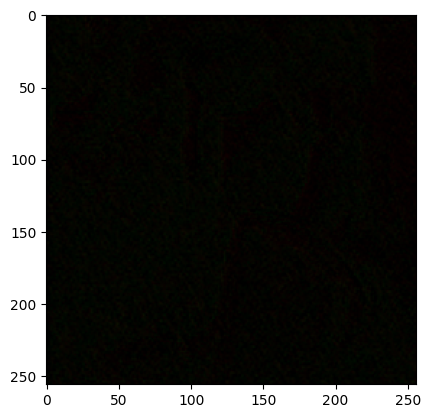

In [32]:
sample_images(2)

[Epoch 0/30] [Batch 0/44] [D VAE_loss: 2.991270, LR_loss: 3.089859] [G loss: 9.992457, pixel: 0.371011, kl: 22.482227, latent: 0.570090] ETA: 8:39:42.228642

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 482.3437999153687


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 482.1139200700488


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 524.880395900511


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 484.98169200754154


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 489.83177116819104


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 510.86438362353647


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 478.76468072451024
1 FID Score: 474.3669788254766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 618.776234920035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 619.3928476188718


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 611.1303988709311


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 632.5107647186893


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 621.1483688801462


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 628.7285236101498


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 619.50476259856
2 FID Score: 616.2351704545897


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 777.3503487721887


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 740.7490354158468


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 771.4467642303224


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 767.6610353233879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 770.7951485390097


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 770.473707718496


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 780.2506651437509
3 FID Score: 758.4620997770801


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 683.0103095986489


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 682.6181436608402


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 666.5392938441673


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 692.1139388132445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 688.0768319502201


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 681.1538590133555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 693.7963412655316
4 FID Score: 673.510485939758


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 449.44966276983024


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 470.1613525352108


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 463.4721766523115


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 467.1219146863032


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 453.6566498194175


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 447.89418602781103


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 459.87939946671247
5 FID Score: 466.7609828191564


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 430.1181040247026


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 441.81624295454213


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 423.87691299450285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 455.2641234392096


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 443.0445548636432


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 454.53620526722653


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 443.55556559512786
6 FID Score: 435.8261434836791


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 900.599387402922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 906.4607003736977


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 896.6810538380798


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 870.7687608169808


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 899.0104284415005


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 870.2136337963319


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 891.8766888248201
7 FID Score: 868.3763534819127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 489.92923476971237


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 519.6951311441732


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 496.35550951730244


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 505.04646074897414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 502.6958994964521


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 502.7171477070848


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 492.9463231778104
8 FID Score: 499.17073929655936
[Epoch 2/30] [Batch 12/44] [D VAE_loss: 1.324572, LR_loss: 1.314375] [G loss: 6.646005, pixel: 0.428664, kl: 3.373169, latent: 0.435892] ETA: 1 day, 6:40:23.29133545

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 435.1163169193777


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 431.81790312756715
1 FID Score: 430.99724399350504


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 432.2888637618499


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 431.9026949420621


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 428.5817427501285
1 FID Score: 430.9878020017025


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 431.5576660488606


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 350.22201094737375
2 FID Score: 349.22932375586464


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 356.0723868676381
2 FID Score: 349.6390566166849


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 352.12964680628164
2 FID Score: 345.45607984447406


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 350.89301547691
2 FID Score: 353.25532723134256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 513.8318212206815
3 FID Score: 512.9744552470607


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 517.2200076295439
3 FID Score: 516.6768843013879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 510.5027798726039
3 FID Score: 523.7620318419902


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 521.086685918744
3 FID Score: 519.5535188617996


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 536.1861124964967
4 FID Score: 535.5105721348931


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 534.9634782063473
4 FID Score: 527.056414141487


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 530.5545012052768
4 FID Score: 531.9903108964952


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 540.0466584024692
4 FID Score: 540.0527029912913


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 299.44384557100074
5 FID Score: 290.76188253850023


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 289.7853512157776
5 FID Score: 284.99371148649305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 312.3721385547489
5 FID Score: 289.5689782275684


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 286.34303599456643
5 FID Score: 299.78013571982865


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 395.457535334569
6 FID Score: 386.0460220669145


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 399.54903738654195
6 FID Score: 388.6279179729322


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 396.1713665347956
6 FID Score: 396.07033479457675


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 400.9825193682252
6 FID Score: 386.4790118975387


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 571.5065736410166
7 FID Score: 580.0651745792827


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 570.15190996886
7 FID Score: 571.7353713466083


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 574.6647760709914
7 FID Score: 574.8055460513161


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 580.7014197424138
7 FID Score: 569.1334768638416


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 385.82537836103046
8 FID Score: 379.53488151667113


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 370.4848726566436
8 FID Score: 372.8213219131239


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 373.43996067015485
8 FID Score: 370.9561516491412


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 379.27529287250974
8 FID Score: 365.3310540979863
[Epoch 4/30] [Batch 24/44] [D VAE_loss: 1.516421, LR_loss: 1.713400] [G loss: 4.882094, pixel: 0.338752, kl: 2.309938, latent: 0.424788] ETA: 16:45:47.6479722884259

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 518.6154064488197


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 524.5209204270243


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 544.4791329361816


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 541.0186772238791


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 526.1264575971333


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 540.4578859130867


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 529.0829188269038
1 FID Score: 537.1821663373898


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 330.0674752666517


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 335.67725458337264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 345.3999070906066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 317.7464064240107


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 338.54402338253027


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 319.28411039496507


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 333.20194353003757
2 FID Score: 338.29643934509244


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 567.450447672976


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 568.1574949380108


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 547.4712291810805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 546.5426768492518


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 562.1200209188739


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 583.9388345173796


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 559.076575207991
3 FID Score: 562.7502041039908


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 462.31426919446676


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 464.48861760732683


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 490.03605585884935


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 465.94669167806853


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 471.4126467482322


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 452.82401989753083


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 490.04248180627195
4 FID Score: 442.0235465546319


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 239.2732951137244


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 256.7018248702996


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 259.4387600768653


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 250.999591755319


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 229.1786997343694


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 241.12913540362106


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 226.2456858169596
5 FID Score: 237.63455293180635


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 230.03881587545845


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 225.99505238369358


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 231.41897970270912


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 229.73011782204276


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 233.62223565921698


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 230.31320622372425


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 228.9483111569695
6 FID Score: 227.84339828625454


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 493.41512704886037


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 506.67112723560285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 490.18019291659493


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 483.73500748440074


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 476.43855434759655


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 499.87308034330573


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 480.3446424430458
7 FID Score: 500.63311450991625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 383.76285145608585


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 379.2225965282404


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 376.2208288302419


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 377.43985747492223


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 377.86296992559056


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 383.13483994749276


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 379.8934475084919
8 FID Score: 379.0547598061669
[Epoch 6/30] [Batch 36/44] [D VAE_loss: 1.175568, LR_loss: 1.273745] [G loss: 5.785668, pixel: 0.346365, kl: 2.548265, latent: 0.440737] ETA: 1 day, 2:04:01.0889915

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 387.1519731342527


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 421.29902919591746
1 FID Score: 399.79895184933133


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 396.8716979829848


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 394.22162090009067


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 400.98008881419236


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 387.1919020434249
1 FID Score: 399.70762287672375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 302.53474413914483


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 292.49886699785526


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 282.77014597223155


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 296.8598141409192


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 288.3511443249847


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 297.25831944941575


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 308.74084164159495
2 FID Score: 277.1594007611705


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 513.6054997372169


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 524.0468663194063


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 499.8747874890734
3 FID Score: 525.6331106229055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 517.623679611859


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 510.21439183104343
3 FID Score: 516.7237366647495


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 503.07383900629


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 440.167348420638


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 445.22105036101226
4 FID Score: 436.09124188823364


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 447.0378321697498


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 449.1809366394953


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 427.30152047274817


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 419.80934642665164
4 FID Score: 448.2991796394672


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 235.2053806654226


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 218.23910244434254


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 250.3823412365922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 235.0037656631323


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 264.7992814208852


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 224.1972790886494


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 235.90000347619008
5 FID Score: 245.98514630506


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 416.10673190143945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 408.0992843584627


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 410.9793507797474


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 411.5953554653698


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 404.3883964058265


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 416.2167839617162


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 412.17666507469824
6 FID Score: 412.5877837967057


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 470.7474703259345


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 477.188354522576


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 485.84925758469916
7 FID Score: 469.96827452531016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 476.3843803021885


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 479.3401301383497


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 484.41492842019966
7 FID Score: 464.257003249306


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 414.9198649677884


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 415.33526957876137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 420.2860398950476


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 416.7339261601114


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 412.4098746111073


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 417.2042853815344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 419.8382787766164
8 FID Score: 421.98667924726465
[Epoch 9/30] [Batch 4/44] [D VAE_loss: 1.589160, LR_loss: 1.574322] [G loss: 5.290265, pixel: 0.344128, kl: 2.793095, latent: 0.404596] ETA: 22:26:03.63766706600768

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 456.1085594245858


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 493.0627318673914
1 FID Score: 485.33406256332444


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 484.0150885302443
1 FID Score: 486.78198964547227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 488.358456926386
1 FID Score: 499.5930460638364


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 476.21150085357004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 320.6682041065519
2 FID Score: 319.48636576620584


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 306.7628544187171
2 FID Score: 301.563950855651


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 310.9163137713062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 309.8426546349224
2 FID Score: 309.69610477170875
2 FID Score: 315.089892439578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 446.90946359952557
3 FID Score: 451.9746429636511


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 461.2989557570602
3 FID Score: 462.94433293580744


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 451.3280579740445
3 FID Score: 452.4431387640735


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 460.0963021591624
3 FID Score: 463.3034037088101


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 460.9496705369129
4 FID Score: 447.2724302588612


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 453.1469662469072


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 468.68132832416217
4 FID Score: 471.76354667556365


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 443.72021697926334
4 FID Score: 451.49382928871336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 457.9435369976499


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 301.1535622634798
5 FID Score: 297.02573625609904


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 290.3879189225153
5 FID Score: 283.9564288600654


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 318.9663132370265
5 FID Score: 302.3244040078655


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 313.7612586281855
5 FID Score: 299.13617662115774


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 257.06255787681386
6 FID Score: 262.8998243303247


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 252.27916163292815
6 FID Score: 256.99708889126623


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 258.1402068561588
6 FID Score: 256.33014915603604


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 262.14504904224276
6 FID Score: 258.2247572273118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 423.16138263629404
7 FID Score: 415.16351647728516


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 421.88449593278744


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 412.5742010817466
7 FID Score: 418.04295238485446


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 423.68676694672644
7 FID Score: 413.3585516314619
7 FID Score: 420.814760367324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 384.7340128387719
8 FID Score: 382.95275885294876


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 373.2026507830442
8 FID Score: 386.4313359963355


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 381.85655502706766
8 FID Score: 374.81898734235375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 382.12643678559334
8 FID Score: 375.1446710126392
[Epoch 11/30] [Batch 16/44] [D VAE_loss: 1.507226, LR_loss: 1.866574] [G loss: 3.863895, pixel: 0.292051, kl: 4.561740, latent: 0.425178] ETA: 20:26:51.9882546247

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 399.048525585117


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 377.131973898378
1 FID Score: 399.41689248245194


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 389.954745353745
1 FID Score: 387.52849533873973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 381.83505332397584
1 FID Score: 390.8161591654706
1 FID Score: 410.02638700943885


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 419.573456350033
2 FID Score: 446.6073159947025


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 464.46703033587164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 462.95951446487607
2 FID Score: 432.88930342182664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 429.562486465657
2 FID Score: 437.92360058863716
2 FID Score: 459.9800514248374


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 449.183783704763
3 FID Score: 452.7507981713513


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 459.8569342722205
3 FID Score: 438.14003403332725


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 469.41498034499716
3 FID Score: 445.23712941342643


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 448.8506779263674
3 FID Score: 438.4071466742077


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 375.2762842311418
4 FID Score: 358.7928712499026


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 399.14090828617105
4 FID Score: 339.8412922220413


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 348.48043775836334
4 FID Score: 344.58268381973903


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 356.1908570391334
4 FID Score: 347.10465897176454


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 251.68663460655668
5 FID Score: 264.6750516043335


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 272.06046124261815
5 FID Score: 250.3796545714793


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 280.34763600762557
5 FID Score: 254.26398990164031


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 269.19754983054344
5 FID Score: 245.24648175431037


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 308.26246163625103
6 FID Score: 293.2501278357088


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 277.9754814904547
6 FID Score: 308.60459062421376


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 295.125671092702
6 FID Score: 284.7086095390528


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 302.01420313269705
6 FID Score: 291.53795173423896


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 479.17102063401444
7 FID Score: 443.7232577825688


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 472.9853240472606
7 FID Score: 469.2308036388098


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 437.3224777227577
7 FID Score: 465.54510669982125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 455.9923970476584
7 FID Score: 472.75733846030715


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 293.4461608621405
8 FID Score: 280.22391875439735


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 278.75991915779974
8 FID Score: 290.6483700410969


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 282.9996714337202


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 274.869819454883
8 FID Score: 269.9785482860622
8 FID Score: 309.22674244548875
[Epoch 13/30] [Batch 28/44] [D VAE_loss: 1.446759, LR_loss: 1.334742] [G loss: 6.156713, pixel: 0.407503, kl: 3.260570, latent: 0.405450] ETA: 11:07:46.401558547321

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 400.6810942356728


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 400.5269430542692
1 FID Score: 384.84262846025445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 406.29492441087086


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 408.79588896441436
1 FID Score: 407.3849035448804


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 407.00077041232277
1 FID Score: 400.664386449592


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 426.06136974953904
2 FID Score: 423.9526140790181


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 445.0170514502227
2 FID Score: 456.0650900504899


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 439.1730247923418
2 FID Score: 439.23343401985943


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 461.3351241072951
2 FID Score: 431.898845609912


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 561.1178927506442


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 558.9290387322104
3 FID Score: 553.2237751710275


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 561.1857118004464
3 FID Score: 559.9886603908324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 559.9447454255139
3 FID Score: 557.9220999232334
3 FID Score: 567.585816399414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 437.6290545683787
4 FID Score: 444.8783547907307


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 432.9368850213854
4 FID Score: 453.8285121001348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 450.2454582608892
4 FID Score: 456.5838160627915


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 453.3397972376067
4 FID Score: 455.11015426184747


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 185.00785423240592
5 FID Score: 179.53128037094868


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 178.66000885338866
5 FID Score: 175.20214910088401


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 177.2523213388755


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 181.32620073686823
5 FID Score: 186.61748710812307


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 182.1800232425362


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 385.3568010699297
6 FID Score: 376.633684050791


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 386.66685429421483
6 FID Score: 385.4017802328383


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 381.77540524645764
6 FID Score: 387.35611703852095


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 381.7961162664767
6 FID Score: 399.16020105059766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 508.4338799080649


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 522.544791083518
7 FID Score: 525.5195375195136


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 519.6506954328806
7 FID Score: 509.7627705977737


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 502.0676295541544


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 533.607419941366
7 FID Score: 509.0485813308358


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 226.722554742136
8 FID Score: 217.3820533402113


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 218.32156857722293
8 FID Score: 219.5356470187014


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 230.781679101207


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 235.83730684205528
8 FID Score: 237.52791039942608


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 222.36709660969564
[Epoch 15/30] [Batch 40/44] [D VAE_loss: 1.284144, LR_loss: 1.161503] [G loss: 4.967619, pixel: 0.324794, kl: 1.419290, latent: 0.380179] ETA: 15:19:20.050721

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 412.4707037083468


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 408.333380291253


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 419.72541502782747
1 FID Score: 400.0397624515659


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 424.62998372370305
1 FID Score: 409.5190801156326


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 413.4655511393595
1 FID Score: 409.19450755382655


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 384.4616737763537


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 385.77212197609543


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 382.4449786054886


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 391.533615574165


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 380.12891629073954


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 387.7398372022673


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 395.1884743591321
2 FID Score: 378.76787160174746


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 286.62530068213675


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 276.680772179376


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 276.67211599006527


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 278.54626333659337


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 291.1044097694272


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 284.0349545585803


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 279.99171131225364
3 FID Score: 289.4317085150208


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 366.3691034091414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 347.95690816242393


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 363.1761834597054


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 370.3951947311542


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 355.2200635326995


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 356.20681561494774
4 FID Score: 361.1014276120551


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 352.71326081075614


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 180.72253987474926
5 FID Score: 187.0336764091392


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 193.77191913020465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 185.22967405921054


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 187.43070152588834


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 185.25880789811325


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 190.3846505410137
5 FID Score: 191.01619716635753


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 189.88161614736134


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 195.43575311446094


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 195.98804568450086


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 193.5878486814328
6 FID Score: 188.68504695811137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 192.7916417965248


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 183.6663545682935
6 FID Score: 185.61876240120972


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 355.07232626361395
7 FID Score: 347.4701821468647


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 347.9067290022729


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 344.4327097650826


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 329.95814990586985


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 357.19006439338654


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 353.75696833914117
7 FID Score: 358.8994531326059


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 308.2801507604239


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 311.59320675694687


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 301.3796083458973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 309.24177938150945
8 FID Score: 294.8064901373551


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 304.5342499875282


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 314.87813304683914
8 FID Score: 303.50489386310295
[Epoch 18/30] [Batch 8/44] [D VAE_loss: 1.537725, LR_loss: 1.347796] [G loss: 4.300479, pixel: 0.247316, kl: 1.486790, latent: 0.441878] ETA: 13:04:28.4700307

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 412.96936393066073


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 395.74027794342106


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 403.3642763751077
1 FID Score: 406.22447396154934


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 403.6443129424301
1 FID Score: 410.22655549486353


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 402.0051456459928
1 FID Score: 397.8919585296403


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 305.3226568383925
2 FID Score: 309.17155558580157


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 301.4312050644672
2 FID Score: 298.46798780121696


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 308.0392504290677
2 FID Score: 307.63786544191305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 303.0784011608048
2 FID Score: 310.7125659134554


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 477.64793462715244
3 FID Score: 476.1221574175976


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 478.58650597496273
3 FID Score: 479.74071232924234


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 465.4079102494338
3 FID Score: 501.0949891996611


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 476.85629815019496
3 FID Score: 495.76758215564496


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 474.625632796859
4 FID Score: 493.8863785543915


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 470.54750256265316
4 FID Score: 472.2500312061403


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 479.29374647915296


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 478.7741130123329
4 FID Score: 476.76624283500183
4 FID Score: 488.90906936886444


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 381.36807280413717
5 FID Score: 376.85124854431587


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 382.4165923438711
5 FID Score: 377.9416356415131


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 373.80200968139286


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 377.3961559174073
5 FID Score: 381.7460944243101
5 FID Score: 367.3173637914684


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 314.5331160259583


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 312.8772559299651
6 FID Score: 309.35819293901426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 311.1784187564322


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 315.08540512571494
6 FID Score: 314.6658761093022


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 306.23801876274007
6 FID Score: 311.6642339403958


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 654.3559060764773


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 659.2734517722271


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 654.0363173400524
7 FID Score: 628.8811397462176


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 643.6543303565534
7 FID Score: 652.7376320777114


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 643.6709092330719
7 FID Score: 652.0363155709762


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 363.6822794312558
8 FID Score: 365.4026978787142


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 362.56433136993934
8 FID Score: 356.6091728113482


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 362.4316992765172
8 FID Score: 349.775676625032


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 339.46906884589487
8 FID Score: 372.61365479525733
[Epoch 20/30] [Batch 20/44] [D VAE_loss: 1.563543, LR_loss: 1.318138] [G loss: 3.929895, pixel: 0.242928, kl: 1.579162, latent: 0.349194] ETA: 6:29:25.2536349

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 381.1335950678916


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 380.19291115404985


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 380.1783062650496


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 370.02845960818587


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 379.24870735103264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 380.9026862895683


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 369.6773307032612
1 FID Score: 380.3926724771776


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 345.5906619161815


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 311.82901462579633


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 322.6115560268726


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 317.26014263129434


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 328.89706475858867


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 348.1729534307188


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 327.1133162130469
2 FID Score: 331.3675417234239


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 562.7422863815161


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 534.5361367464643


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 547.6793410101185


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 551.3705674906522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 557.6196612570884


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 552.6249748266602


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 614.013819225192
3 FID Score: 548.7260662540239


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 374.48930601718973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 380.15351925037726


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 361.99645382511494


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 370.94080695717776


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 378.4802765161219


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 321.4874320668508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 382.9894257804671
4 FID Score: 377.1591114866614


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 199.17704306387492


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 188.38136390448528


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 192.76735430376556


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 193.0959233673939


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 191.02622848478595


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 197.6730296765946


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 194.88347245265825
5 FID Score: 190.5028626553325


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 326.6034917997444


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 332.87843618694495


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 329.4086237934664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 332.6224747060359


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 364.3466010869204


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 328.6578441510021


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 336.41191193431587
6 FID Score: 341.0950289685027


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 524.5243660964949


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 501.31849031148045


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 528.996002366315


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 517.2967754659331


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 506.66881146037736


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 527.0684421438931


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 530.8941439941751
7 FID Score: 526.1730491815571


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 356.5475654410612


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 381.414430155739


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 351.79086940757713


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 344.9407832768386


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 351.4989938333185


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 380.07584644818076


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 347.8250788385146
8 FID Score: 355.6542197130449
[Epoch 22/30] [Batch 32/44] [D VAE_loss: 1.522318, LR_loss: 1.568533] [G loss: 3.935281, pixel: 0.205327, kl: 1.146064, latent: 0.380656] ETA: 7:49:16.3069159

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 352.4268991048933


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 347.72601434953157


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 356.89865890461215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 348.0905651416968


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 349.08477212146363


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 349.1893770968766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 FID Score: 345.7573877321727
1 FID Score: 334.9885620782128


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 274.37030159673276


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 283.23687275199967


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 275.8509585101743


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 274.6756478047667


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 278.45170009748267


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 279.5977462886309
2 FID Score: 269.7969506085215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 FID Score: 278.9638863081427


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 406.25339114915096


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 429.74652009004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 437.61479894545215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 437.70486072956686


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 431.3738899050802
3 FID Score: 415.45198918531867


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 FID Score: 430.58430122758995
3 FID Score: 431.12554574134833


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 329.8725596105869


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 323.392317079076
4 FID Score: 328.8093978263042


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 331.2593915946216


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 319.8090215187495


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 324.48066273117445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 FID Score: 318.7613706543576
4 FID Score: 331.0668083726125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 193.35030417566622


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 204.2517995808783


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 211.77702111249036


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 204.03779277170835


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 198.1042639209583
5 FID Score: 203.93625314336455


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 FID Score: 198.93602494086062
5 FID Score: 187.03505541558164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 279.9084778836564


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 282.5207236304844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 260.4505310960056


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 267.24146412966235
6 FID Score: 283.70394993642606


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 273.26126410161737
6 FID Score: 291.58392582112543


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6 FID Score: 271.37726088684684


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 494.78824101796687


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 502.2021632155022


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 485.31784382045953


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 502.2150570567918


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 497.7488779087602
7 FID Score: 492.5185280473785


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7 FID Score: 502.0545380237413
7 FID Score: 501.0690815041411


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 174.89345679396183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 185.1692027389834


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 210.9919645858388
8 FID Score: 261.8475631503548


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 227.60559600390175


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 203.88890220362035
8 FID Score: 200.41635331068733


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8 FID Score: 186.06548824151128
[Epoch 23/30] [Batch 3/44] [D VAE_loss: 1.306469, LR_loss: 1.374661] [G loss: 4.017045, pixel: 0.224219, kl: 1.781712, latent: 0.495103] ETA: 1:33:24.55039517

KeyboardInterrupt: 

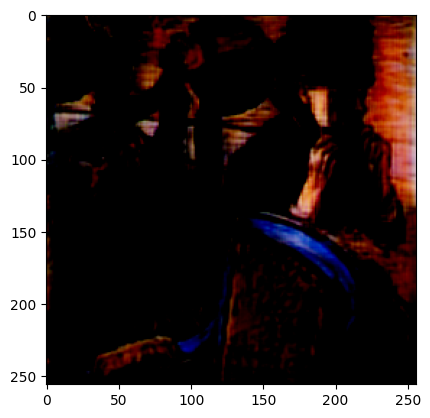

In [33]:
# Adversarial loss
kl_loss = []
VAE_loss = []
LR_loss = []
pixel_loss = []
latent_loss = []
valid = 1
fake = 0
prev_time = time.time()
for epoch in range(epoch, n_epochs):
    total_samples = 0
    total_kl_loss = 0
    total_VAE_loss = 0
    total_LR_loss = 0
    total_pixel_loss = 0
    total_latent_loss = 0
    for i, batch in enumerate(train_loader): 
        length_batch = batch["A"].shape[0]
        total_samples += length_batch
        # Set model input
        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))
        # print(real_A.shape, real_B.shape)
        # -------------------------------
        #  Train Generator and Encoder
        # -------------------------------
        optimizer_E.zero_grad()
        optimizer_G.zero_grad()
        # ----------
        # cVAE-GAN
        # ----------
        # Produce output using encoding of B (cVAE-GAN)
        # img_transposed = np.transpose(img, (0, 3, 1, 2))
        # real_B = np.transpose(real_B.cpu(), (0, 3, 1, 2))
        real_B = real_B.cuda()

        mu, logvar = encoder(real_B)
        encoded_z = reparameterization(mu, logvar)

        # real_A = np.transpose(real_A.cpu(), (0, 3, 1, 2))
        real_A = real_A.cuda()

        fake_B = generator(real_A, encoded_z)
        # Pixelwise loss of translated image by VAE
        loss_pixel = mae_loss(fake_B, real_B)
        # Kullback-Leibler divergence of encoded B
        loss_kl = 0.5 * torch.sum(torch.exp(logvar) + mu ** 2 - logvar - 1)
        # Adversarial loss
        loss_VAE_GAN = D_VAE.compute_loss(fake_B, valid)
        # ---------
        # cLR-GAN
        # ---------
        # Produce output using sampled z (cLR-GAN)
        sampled_z = Variable(Tensor(np.random.normal(0, 1, (real_A.size(0), latent_dim))))
        _fake_B = generator(real_A, sampled_z)
        # cLR Loss: Adversarial loss
        loss_LR_GAN = D_LR.compute_loss(_fake_B, valid)
        # ----------------------------------
        # Total Loss (Generator + Encoder)
        # ----------------------------------
        loss_GE = loss_VAE_GAN + loss_LR_GAN + lambda_pixel * loss_pixel + lambda_kl * loss_kl
        loss_GE.backward(retain_graph=True)
        optimizer_E.step()
        # ---------------------
        # Generator Only Loss
        # ---------------------
        # Latent L1 loss
        _mu, _ = encoder(_fake_B)
        loss_latent = lambda_latent * mae_loss(_mu, sampled_z)
        loss_latent.backward()
        optimizer_G.step()
        # ----------------------------------
        #  Train Discriminator (cVAE-GAN)
        # ----------------------------------
        optimizer_D_VAE.zero_grad()
        loss_D_VAE = D_VAE.compute_loss(real_B, valid) + D_VAE.compute_loss(fake_B.detach(), fake)
        loss_D_VAE.backward()
        optimizer_D_VAE.step()
        # ---------------------------------
        #  Train Discriminator (cLR-GAN)
        # ---------------------------------
        optimizer_D_LR.zero_grad()
        loss_D_LR = D_LR.compute_loss(real_B, valid) + D_LR.compute_loss(_fake_B.detach(), fake)
        loss_D_LR.backward()
        optimizer_D_LR.step()
        # --------------
        #  Log Progress
        # --------------
        # Determine approximate time left
        batches_done = epoch * len(train_loader) + i
        batches_left = n_epochs * len(train_loader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()
        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D VAE_loss: %f, LR_loss: %f] [G loss: %f, pixel: %f, kl: %f, latent: %f] ETA: %s"
            % (
                epoch,
                n_epochs,
                i,
                len(train_loader),
                loss_D_VAE.item(),
                loss_D_LR.item(),
                loss_GE.item(),
                loss_pixel.item(),
                loss_kl.item(),
                loss_latent.item(),
                time_left,
            )
        )
        total_kl_loss += loss_kl.item()*length_batch
        total_VAE_loss += loss_D_VAE.item()*length_batch
        total_LR_loss += loss_D_LR.item()*length_batch
        total_pixel_loss += loss_pixel.item()*length_batch
        total_latent_loss += loss_latent.item()*length_batch
        if batches_done % sample_interval == 0:
            sample_images(batches_done)
    # append the loss values for each epoch
    kl_loss.append(total_kl_loss/total_samples)
    VAE_loss.append(total_VAE_loss/total_samples)
    LR_loss.append(total_LR_loss/total_samples)
    pixel_loss.append(total_pixel_loss/total_samples)
    latent_loss.append(total_latent_loss/total_samples)

In [34]:
kl_loss

[7.0349463272094725,
 4.304806532178606,
 5.317890341622489,
 4.416881335122245,
 4.657447588784354,
 3.866406786782401,
 4.2146740136827745,
 5.03877713067191,
 3.8412286240713938,
 3.564598117555891,
 4.214873008728027,
 3.5623018986838204,
 3.506526620047433,
 2.78785918372018,
 2.1076559856959753,
 1.8230438545772008,
 1.7754697459084647,
 1.5957876355307443,
 1.4132078851972307,
 1.638730170386178,
 1.8720849554879324,
 1.6423478194645473,
 1.0556521729060582]

In [35]:
VAE_loss

[1.5730291223526,
 1.7436031069074358,
 1.5220169407980784,
 1.4969513838631767,
 1.4659641960689,
 1.4315116276059832,
 1.4436723273141043,
 1.4756008086885726,
 1.5134906428200858,
 1.4822174535478865,
 1.462752502986363,
 1.4656760426930018,
 1.440449424471174,
 1.4565962205614362,
 1.5184375715255738,
 1.4954258721215383,
 1.48109922681536,
 1.472524209703718,
 1.4766154023579188,
 1.4891770819255283,
 1.4979913806915284,
 1.4945892116001673,
 1.4674937438964843]

In [36]:
pixel_loss

[0.42625223125730244,
 0.3997205054759979,
 0.3675717530931745,
 0.36313712920461383,
 0.35471490229879105,
 0.35049501623426166,
 0.3628642010688782,
 0.36253262434686934,
 0.35941253423690794,
 0.32853880252156936,
 0.326217337506158,
 0.3300136503151485,
 0.32001678841454645,
 0.3067990325178419,
 0.313062732730593,
 0.2899115421090807,
 0.2869504388741084,
 0.27922179937362673,
 0.2857454455750329,
 0.2623651887689318,
 0.25623873020921434,
 0.25528939417430335,
 0.2415334268978664]

In [37]:
LR_loss

[1.7275711795261928,
 1.6703806291307721,
 1.4616344942365374,
 1.5255008009501867,
 1.4890611471448625,
 1.5056000198636736,
 1.4441904640197754,
 1.4583388832637243,
 1.4994552939278738,
 1.5110767269134522,
 1.4937817859649658,
 1.475616431917463,
 1.4782507814679826,
 1.4065406949179513,
 1.4019726392201015,
 1.3822121695109777,
 1.4836343451908656,
 1.418726681300572,
 1.4041355500902448,
 1.545156443459647,
 1.4185272850309099,
 1.363639214379447,
 1.3458094937460763]

In [38]:
latent_loss

[0.41896749019622803,
 0.41613358378410337,
 0.41693393639155796,
 0.42051710639681134,
 0.41600988524300714,
 0.4173101275307792,
 0.42051097972052437,
 0.42049558026450023,
 0.41468345948628016,
 0.4097274809224265,
 0.4198095582212721,
 0.41856744970594134,
 0.42165998544011796,
 0.40427381328174045,
 0.4162221578189305,
 0.41099481735910687,
 0.4053334939479828,
 0.41213606766292027,
 0.4028263706820352,
 0.39646817411695207,
 0.40838542325156074,
 0.41126262766974314,
 0.4102355020386832]

In [39]:
# trained in normalized batch size of 8 and size 256 and resnet 50 for cub to imp
# torch.save(generator.state_dict(), 'cti_generator_weights_256_50_r.pth')
# torch.save(encoder.state_dict(), 'cti_enocder_weights_256_50_r.pth')
# torch.save(D_VAE.state_dict(), 'cti_d_vae_256_50_r.pth')
# torch.save(D_LR.state_dict(), 'cti_d_lr_256_50_r.pth')

FID Scores

In [25]:
import torchvision.models as models

In [26]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

c:\Users\hp\cudaenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [28]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [29]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value